In [1]:
import dalex as dx
import xgboost
import shap

import sklearn

import pandas as pd
import numpy as np

import matplotlib

import warnings
warnings.filterwarnings("ignore")

In [2]:
!wget -nc https://raw.githubusercontent.com/adrianstando/imbalanced-benchmarking-set/main/datasets/churn.csv

File ‘churn.csv’ already there; not retrieving.



# Task A

### 1.Train a tree-based ensemble model on the selected dataset; it can be one of random forest, GBM, CatBoost, XGBoost, LightGBM (various types) etc.

I'll use churn dataset, as it's better described that the one I used in the past (wine quality).

In [3]:
dataset = pd.read_csv('churn.csv', index_col=0)
dataset.head()

,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge,TARGET
0,265.1,45.07,197.4,16.78,244.7,11.01,10.0,2.70,0
1,161.6,27.47,195.5,16.62,254.4,11.45,13.7,3.70,0
2,243.4,41.38,121.2,10.30,162.6,7.32,12.2,3.29,0
3,299.4,50.90,61.9,5.26,196.9,8.86,6.6,1.78,0
4,166.7,28.34,148.3,12.61,186.9,8.41,10.1,2.73,0


In [4]:
X = dataset.drop(columns='TARGET')
y = dataset.TARGET

In [5]:
model = xgboost.XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 2.Select two observations from the dataset and calculate the model's prediction.

In [6]:
observation1Index = 0
observation2Index = 5

In [7]:
observation1 = X.iloc[observation1Index]
observation1

total_day_minutes      265.10
total_day_charge        45.07
total_eve_minutes      197.40
total_eve_charge        16.78
total_night_minutes    244.70
total_night_charge      11.01
total_intl_minutes      10.00
total_intl_charge        2.70
Name: 0, dtype: float64

In [8]:
observation2 = X.iloc[observation2Index]
observation2

total_day_minutes      223.40
total_day_charge        37.98
total_eve_minutes      220.60
total_eve_charge        18.75
total_night_minutes    203.90
total_night_charge       9.18
total_intl_minutes       6.30
total_intl_charge        1.70
Name: 5, dtype: float64

In [9]:
probabilities = model.predict_proba([observation1, observation2])

print(f'The probability of 0 in the first observation is {probabilities[0][0]}')
print(f'The probability of 0 in the second observation is {probabilities[1][0]}')

The probability of 0 in the first observation is 0.837304949760437
The probability of 0 in the second observation is 0.8529270887374878


### 3. Next, for the same observations, calculate the decomposition of predictions, so-called variable attributions, using SHAP from two packages of choice, e.g. for Python: dalex and shap, for R: DALEX and iml.

In [10]:
pf_xgboost_classifier_default = lambda m, d: m.predict_proba(d)[:, 1]

explainer = dx.Explainer(model, X, y, predict_function=pf_xgboost_classifier_default, label="GBM")

Preparation of a new explainer is initiated

  -> data              : 5000 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5000 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : GBM
  -> predict function  : <function <lambda> at 0x7f1ddbfafce0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000151, mean = 0.142, max = 0.998
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.712, mean = -0.000114, max = 0.932
  -> model_info        : package xgboost

A new explainer has been created!


In [11]:
shap_attributions = [explainer.predict_parts(observation, type="shap") for observation in [observation1, observation2]]
shap_attributions[0].plot(shap_attributions[1::])

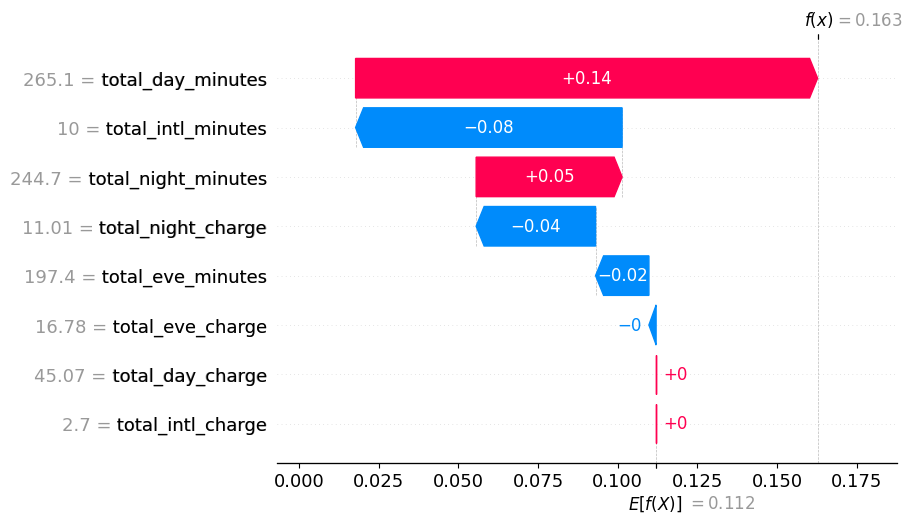

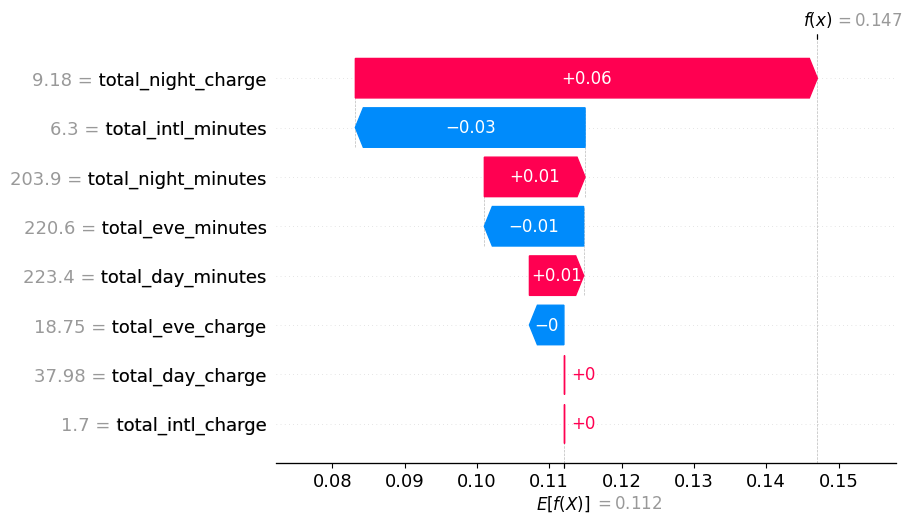

In [12]:
shap_explainer = shap.explainers.Tree(model, data=X, model_output="probability")
shap_values = shap_explainer(X)

shap.plots.waterfall(shap_values[observation1Index])
shap.plots.waterfall(shap_values[observation2Index])

### 4. Find any two observations in the dataset, such that they have different variables of the highest importance, e.g. age and gender have the highest (absolute) attribution for observation A, but race and class are more important for observation B.

In the dalex explanations above, for the first observation the most important are day minutes and international minutes, while in the second one most important are night charge and evening minutes.

### 5. (If possible) Select one variable X and find two observations in the dataset such that for one observation, X has a positive attribution, and for the other observation, X has a negative attribution.

In the observation above, night charge has negative attribution in the first example and positive in the second one.

### 6. (How) Do the results differ across the two packages selected in point (3)?

They do differ slightly on the observations I selected. For example, in the second observation, in dalex evening minutes have a big attribution, while in shap not so much.

### 7. (Using one explanation package of choice) Train another model of any class: neural network, linear model, decision tree etc. and find an observation for which SHAP attributions are different between this model and the one trained in point (1).

In [13]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [14]:
explainer = dx.Explainer(model, X, y, predict_function=pf_xgboost_classifier_default, label="RF")

Preparation of a new explainer is initiated

  -> data              : 5000 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5000 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RF
  -> predict function  : <function <lambda> at 0x7f1ddbfafce0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.144, max = 0.99
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.39, mean = -0.00231, max = 0.52
  -> model_info        : package sklearn

A new explainer has been created!


In [15]:
shap_attributions = [explainer.predict_parts(observation1, type="shap")]
shap_attributions[0].plot(shap_attributions[1::])

In this observation the attributions change, for example the day charge has significant attribution, while in the previous model the attribution was zero.

## Task B

$\psi_A = 1/6 (2 * 20 + 40 + 10 + 2 * 30) = 25$

$\psi_B = 1/6 (2 * 20 + 40 + 10 + 2 * 30) = 25$

$\psi_C = 1/6 (2 * 60 + 50 + 50 + 2 * 40) = 50$

For player A the Shapley value is 25, it contributes 20 to 2 permutations where it's first, 30 to 2 permutations where it's last, 40 to BAC permutation and 10 to CAB permutation.